# Visualising CNNs: The Class Appearance Model

In this example we will demonstrate the [ClassAppearanceModel](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.callbacks.imaging.inside_cnns.ClassAppearanceModel) callback included in torchbearer. This implements
one of the most simple (and therefore not always the most successful) deep visualisation techniques, discussed in the
paper [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034) 

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install Torchbearer

First we install torchbearer if needed.


In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
print(torchbearer.__version__)

0.4.0.dev


## Background

The process to obtain Figure 1 from the paper is simple, given a particular target class $c$, we use
back-propagation to obtain

\begin{equation}
\arg\!\max_I \; S_c(I) - \lambda\Vert I \Vert_2^2\; ,
\end{equation}

where $S_c(I)$ is the un-normalised score of $c$ for the image $I$ given by the network. The
regularisation term $\Vert I \Vert_2^2$ is necessary to prevent the resultant image from becoming overly noisy.
More recent visualisation techniques use much more advanced regularisers to obtain smoother, more realistic images.

## Loading the Model

Since we are just running the callback on a pre-trained model, we don't need to load any data in this example. Instead,
we use torchvision to load a VGG16 trained on ImageNet with the following:

In [2]:
import torch.nn as nn
import torchvision

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.net = torchvision.models.vgg16(True)

    def forward(self, input):
        if input is not None:
            return self.net(input)

model = Model()

We need to include the `None` check as we will initialise the `Trial` without a dataloader, and so it will pass
`None` to the model forward.

## Running with the Callback

When producing gradient based visualisations, we commonly need to include a transform to convert the input to the right space.
For torchvisions ImageNet models we can use the following:

In [3]:
from torchvision import transforms

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

Finally we can construct and run the `Trial` with:

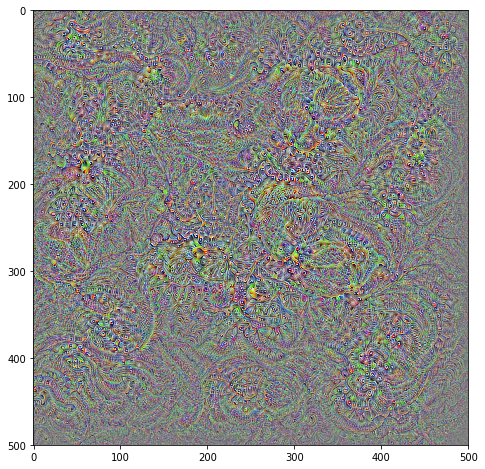

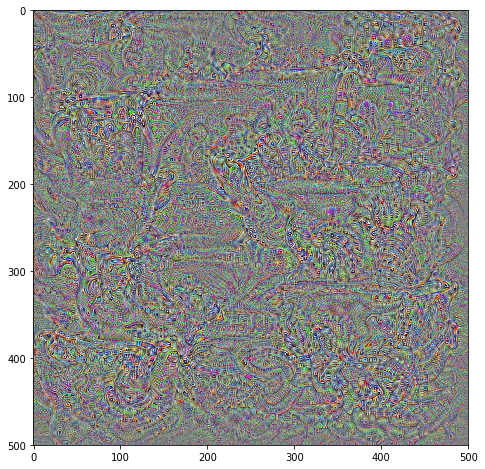

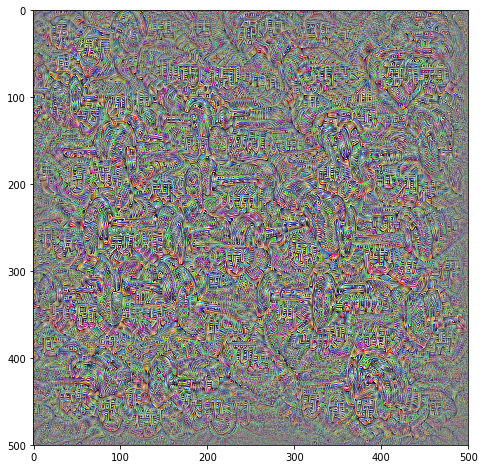

{}

In [4]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)

import torch
from torchbearer import Trial
from torchbearer.callbacks import imaging

device = 'cuda' if torch.cuda.is_available() else 'cpu'

trial = Trial(model, callbacks=[
    imaging.ClassAppearanceModel(1000, (3, 500, 500), steps=128, target=951, decay=0.002, in_transform=normalize)
              .on_val().to_pyplot().to_file('lemon.png'),
    imaging.ClassAppearanceModel(1000, (3, 500, 500), steps=128, target=968, decay=0.002, in_transform=normalize)
              .on_val().to_pyplot().to_file('cup.png'),
    imaging.ClassAppearanceModel(1000, (3, 500, 500), steps=128, target=543, decay=0.002, in_transform=normalize)
              .on_val().to_pyplot().to_file('dumbbell.png')
])
trial.for_val_steps(1).to(device)
trial.evaluate()

Here we create two `ClassAppearanceModel` instances which target the `lemon`, `cup` and `dumbbell` classes respectively. Since the `.ClassAppearanceModel` is an `ImagingCallback`, we use the imaging API to send each of these to files. Finally, we evaluate the model for a single step to generate the results.

## Results

There are some shapes which resemble a lemon, cup or dumbbell, however, not quite to the same extent shown in the paper. Because of the simplistic regularisation and objective, this model is highly sensitive to hyper-parameter choices. These results could almost certainly be improved with some more careful selection.